# PHOEBE for binary fitting #

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline

First we need to download the data that we will try to fit:
[lc.data](https://iacerasmus.github.io/ERASMUS2022/data/lc.data)
[rv2.data](https://iacerasmus.github.io/ERASMUS2022/data/rv1.data)
[rv2.data](https://iacerasmus.github.io/ERASMUS2022/data/rv2.data)

Now load the phoebe default binary and add those datasets to the bundle

/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


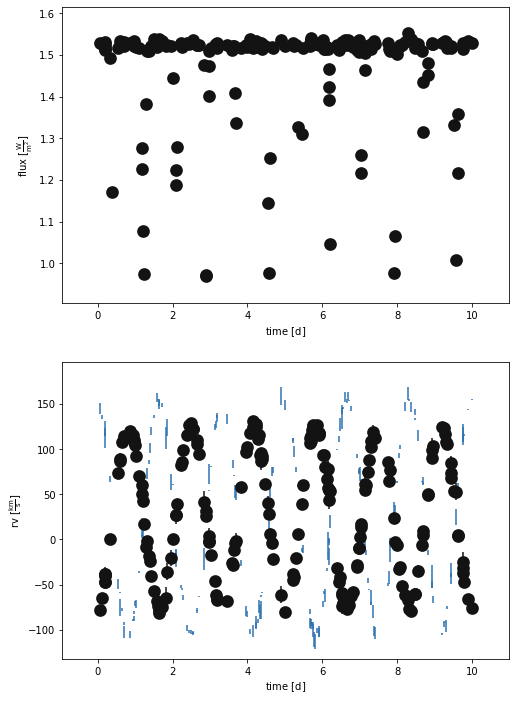

In [2]:
b = phoebe.default_binary()
lc_times, lc_fluxes, lc_errs = np.loadtxt('lc.data',unpack=True)
rv1_times, rv1_rvs, rv1_errs = np.loadtxt('rv1.data',unpack=True)
rv2_times, rv2_rvs, rv2_errs = np.loadtxt('rv2.data',unpack=True)

b.add_dataset('lc', times = lc_times, fluxes=lc_fluxes, sigmas=lc_errs, passband='Johnson:V')
b.add_dataset('rv')
b['times@rv@primary'], b['rvs@rv@primary'], b['sigmas@rv@primary'] = rv1_times, rv1_rvs, rv1_errs
b['times@rv@secondary'], b['rvs@rv@secondary'], b['sigmas@rv@secondary'] = rv2_times, rv2_rvs, rv2_errs
_ = b.plot(x='times', show=True)

Let's evaluate the default binary just to see how bad it is

100%|██████████| 200/200 [00:04<00:00, 41.34it/s]
/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


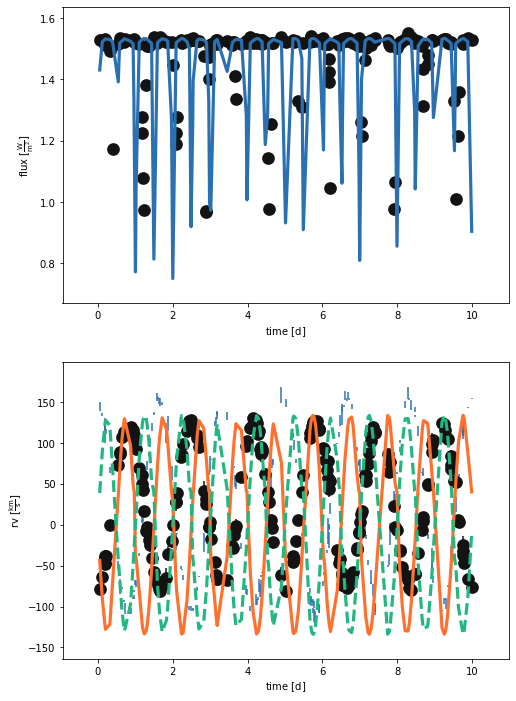

In [3]:
b.set_value('pblum_mode', 'dataset-scaled')
b.run_compute(model='default')
_ = b.plot(x='times', show=True)

What a mess! Delete that model...

In [4]:
b.remove_model('default')

<ParameterSet: 10 parameters | contexts: figure, model>

Let's first try to fix the period.  We can start by looking at the RVs (PHOEBE's periodogram is built upon the astropy implementation of the LS periodogram)

In [5]:
b.add_solver('estimator.rv_periodogram', solver='rvperiod')
print(b['rvperiod'])

ParameterSet: 8 parameters
         comments@rvperiod@solver: 
       use_server@rvperiod@solver: none
        algorithm@rvperiod@solver: ls
      rv_datasets@rvperiod@solver: ['*']
        component@rvperiod@solver: binary
      sample_mode@rvperiod@solver: auto
   samples_per_peak@rvperiod@s...: 10
   nyquist_factor@rvperiod@solver: 5


Let's not touch the parameters for now, just to see what it comes up with

In [6]:
b.run_solver('rvperiod', solution='rvperiod_solution')
print(b['rvperiod_solution'])

ParameterSet: 10 parameters
R  period@rvperiod_solution@so...: [ 0.40235315  0.41241198  0.42247081
 ... 40.01402079 40.02407961
 40.03413844] d
R  power@rvperiod_solution@sol...: [0.562767   0.55478154 0.55243615 ...
 0.71461299 0.71365716 0.70937088]
   period_factor@rvperiod_solu...: 1.0
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [0.6035297252658087]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution@...: 


From looking directly at the data, that period looks a bit off.  Let's plot the periodogram itself

(0.0, 5.0)

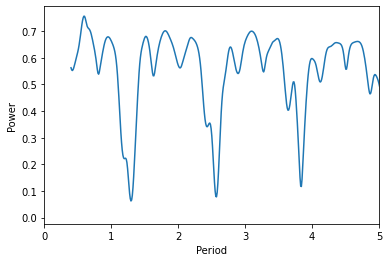

In [7]:
plt.plot(b['period@rvperiod_solution'].value,b['power@rvperiod_solution'].value)
plt.xlabel('Period')
plt.ylabel('Power')
plt.xlim([0,5])

Ugly! But from our data, we can estimate that the period is roughly 1-2 days. So let's evaluate the periodogram only for this range

In [8]:
b.set_value('sample_mode', context='solver', solver='rvperiod', value='manual')
b.set_value('sample_periods', context='solver', solver='rvperiod', value=np.linspace(1.,2.,200))
b.run_solver('rvperiod', solution='rvperiod_solution_2')
print(b['rvperiod_solution_2'])

ParameterSet: 10 parameters
R  period@rvperiod_solution_2@...: [2.         1.99497487 1.98994975 ...
 1.01005025 1.00502513 1.        ] d
R  power@rvperiod_solution_2@s...: [0.61878495 0.62016585 0.62157344 ...
 0.67033284 0.66801086 0.66549368]
   period_factor@rvperiod_solu...: 1.0
R  fitted_twigs@rvperiod_solut...: ['period@binary@orbit@component']
R  fitted_values@rvperiod_solu...: [1.6683417085427137]
R  fitted_units@rvperiod_solut...: ['d']
   adopt_parameters@rvperiod_s...: ['period@binary@orbit@component']
   adopt_distributions@rvperio...: False
   adopt_values@rvperiod_solut...: True
   comments@rvperiod_solution_...: 


This looks better.  It doesn't need to be exact as we can refine this with our fits later.

/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


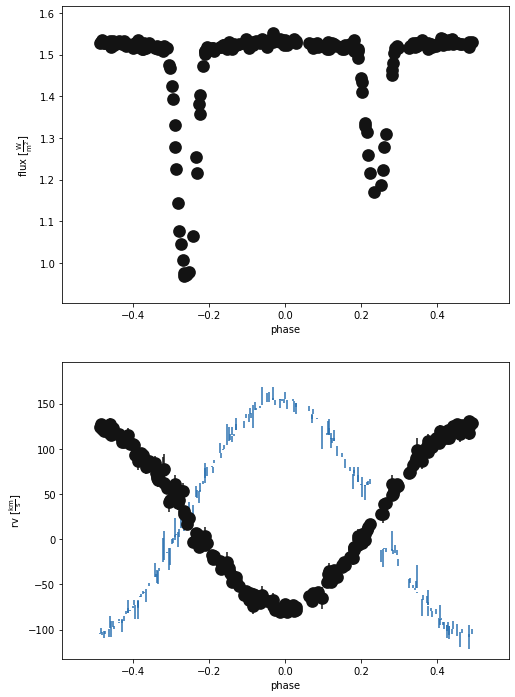

(<autofig.figure.Figure | 2 axes | 3 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [9]:
b.adopt_solution('rvperiod_solution_2')
b.plot(x='phase', show=True)

Looks good!

Now we can start estimating parameters from the geometry of both the RV and light curves

In [10]:
b.add_solver('estimator.rv_geometry', solver='rvgeom', overwrite=True)
b.run_solver('rvgeom', solution='rvgeom_solution')

<ParameterSet: 17 parameters | components: primary, secondary>

For now, let's just blindly accept the results of the solver (in real life you'd probably want to inspect things, but we don't have time!)

100%|██████████| 200/200 [00:17<00:00, 11.48it/s]
/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


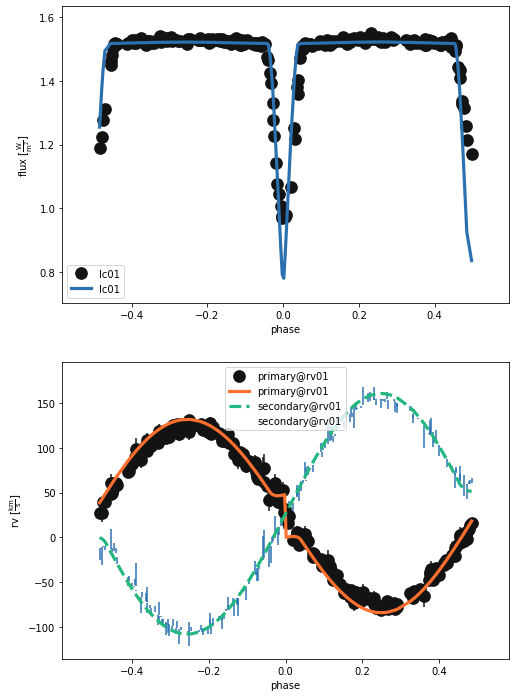

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [11]:
#rv_geometry solves for asini, which by default is constrained by sma, so we need to flip this in phoebe
b.flip_constraint('asini@binary', solve_for='sma@binary')
b.adopt_solution('rvgeom_solution')
b.run_compute(model='rvgeom_model')
b.plot(x='phase', legend=True, show=True)

As you might expect, letting the RV curve geometry set some parameters (t0, q, gamma, asini) makes the RV curve look good but doesn't do much for the LC (except tidy up the phasing). So, we need to use the light curve.  We could jump straight to using the lc_geometry but this doesn't fit for the inclination. So, let's try using phoebe's EBAI estimator first.

In [12]:
b.add_solver('estimator.ebai', ebai_method='mlp', solver='ebai_mlp_est')
b.run_solver('ebai_mlp_est', solution='ebai_mlp_solution')

<ParameterSet: 13 parameters | qualifiers: input_sigmas, adopt_values, ebai_fluxes, input_fluxes, fitted_values, fitted_twigs, input_phases, ebai_phases, adopt_distributions, comments, orbit, adopt_parameters, fitted_units>

100%|██████████| 200/200 [00:18<00:00, 10.82it/s]
/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


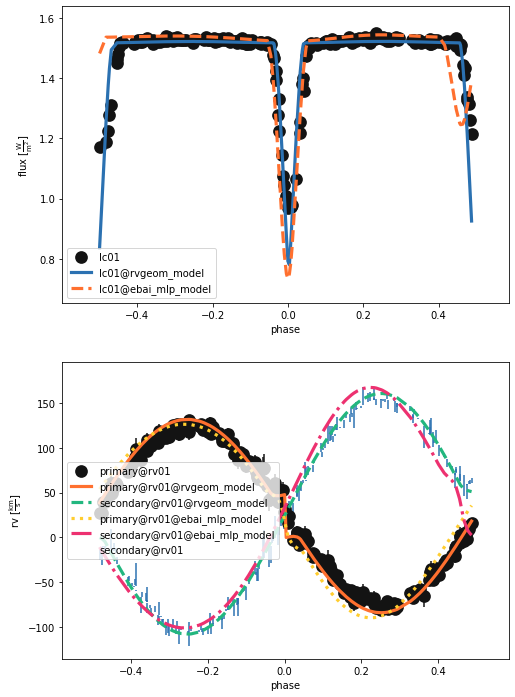

(<autofig.figure.Figure | 2 axes | 9 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [13]:
# flip constraints so we can adopt the solution
b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')
b.flip_constraint('requivratio', solve_for='requiv@secondary')
b.flip_constraint('requivsumfrac', solve_for='requiv@primary')
b.flip_constraint('teffratio', solve_for='teff@secondary')

# adopt solution and compute the model
b.adopt_solution('ebai_mlp_solution')
b.run_compute(model='ebai_mlp_model')
b.plot(x='phase', legend=True, show=True)

Getting there! Now let's go with the lc_geometry estimator to finish our estimation of the system parameters.

In [14]:
b.add_solver('estimator.lc_geometry', solver='lcgeom')
b.run_solver('lcgeom', solution='lcgeom_solution')

<ParameterSet: 21 parameters | qualifiers: analytic_fluxes, analytic_best_model, input_fluxes, fitted_values, comments, adopt_values, adopt_distributions, secondary_phase, primary_width, analytic_phases, secondary_depth, primary_phase, eclipse_edges, primary_depth, fitted_twigs, orbit, input_sigmas, secondary_width, input_phases, adopt_parameters, fitted_units>

100%|██████████| 200/200 [00:18<00:00, 10.93it/s]
/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


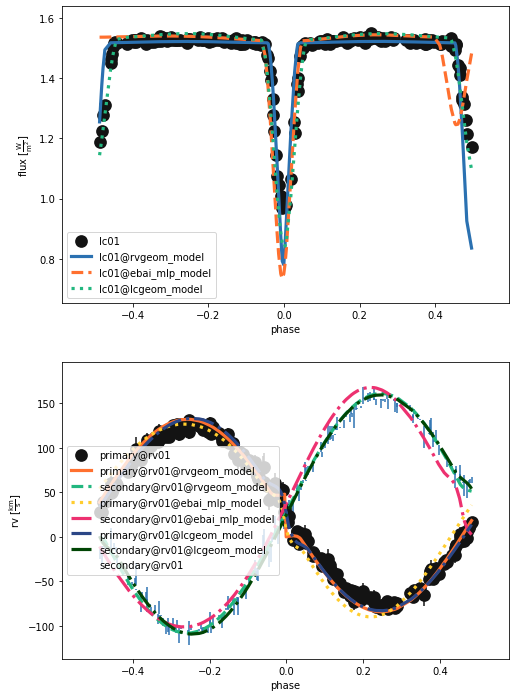

(<autofig.figure.Figure | 2 axes | 12 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [15]:
# lc_geometry returns ecc and per0, so we need to flip the constraints back before adopting the solution
b.flip_constraint('ecc', solve_for='esinw')
b.flip_constraint('per0', solve_for='ecosw')

b.adopt_solution('lcgeom_solution')
b.run_compute(model='lcgeom_model')
b.plot(x='phase', legend=True, show=True)

/usr/local/lib/python3.9/site-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


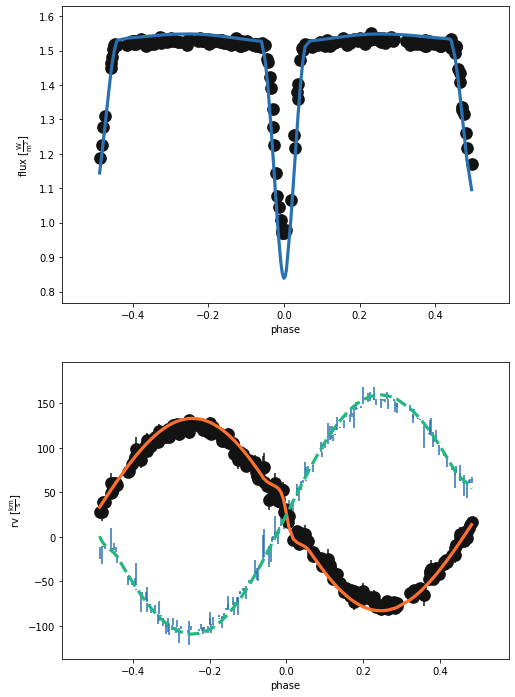

(<autofig.figure.Figure | 2 axes | 6 call(s)>,
 <Figure size 576x864 with 2 Axes>)

In [16]:
#Just plotting the most recent fit
b.plot(['dataset', 'lcgeom_model'], x='phase', show=True)


Not terrible, but clearly not quite right. We've estimated, now let's optimise! We can use the Nelder-Mead method as it is incorporated into phoebe

In [17]:
b.add_compute(
    compute='nm_fit',
    irrad_method='none',
    rv_method='dynamical',
    distortion_method='sphere'
) #This just changes a few compute parameters to speed up the solver

b.add_solver('optimizer.nelder_mead',  solver='nm_solver', compute='nm_fit')
b.set_value('maxiter', solver='nm_solver', value=20)


If we try to run the optimiser on all the data and for every parameter, this will take quite a long time. So, let's try to be clever and start with just the RV data and fit only to RV sensitive parameters.

In [18]:
b.disable_dataset('lc01')
b['fit_parameters@nm_solver'] = ['vgamma@system', 't0_supconj@binary', 'q@binary', 'asini@binary']
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)

100%|██████████| 20/20 [00:48<00:00,  2.40s/it]


<ParameterSet: 11 parameters | qualifiers: success, adopt_values, niter, fitted_units, fitted_values, initial_values, fitted_twigs, message, comments, adopt_parameters, adopt_distributions>

Let's adopt that solution so we can run_compute and check it visually.

Wed, 14 Sep 2022 09:18 BUNDLE       WARNING applying passed solution (nm_solution) to sample_from
Wed, 14 Sep 2022 09:18 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_solution=False
Wed, 14 Sep 2022 09:18 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [00:00<00:00,  1.12it/s]


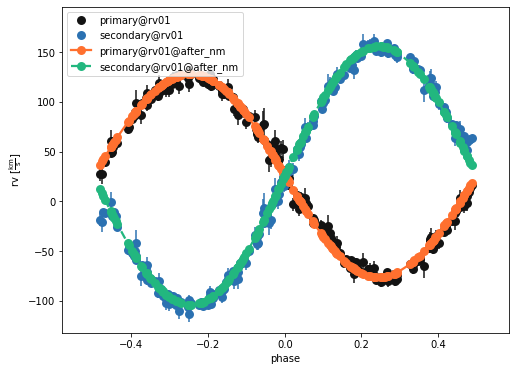

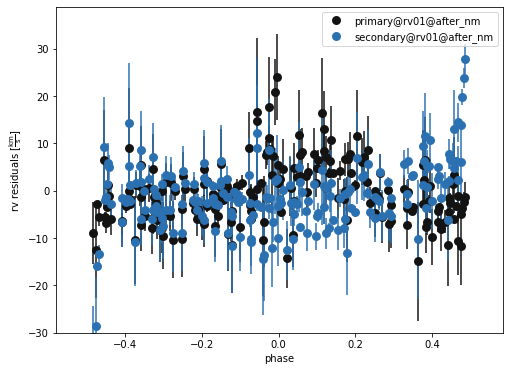

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [19]:
b.adopt_solution('nm_solution')
b.run_compute('nm_fit', solution='nm_solution', model='after_nm', overwrite=True)

b.plot(kind='rv', model='after_nm', x='phases', show=True, legend=True, marker = 'o')
b.plot( kind='rv', model='after_nm', x='phases', y='residuals', show=True, legend=True, marker = 'o')


Ok, now let's go back to the LC

In [20]:
b.disable_dataset('rv01')
b.enable_dataset('lc01')

<ParameterSet: 18 parameters | components: primary, secondary, binary>

Running the optimiser for *all* data is expensive, so we can fit just to the eclipse regions.  The simplest way to do this is to mask the data using our previous lc_geometry solution

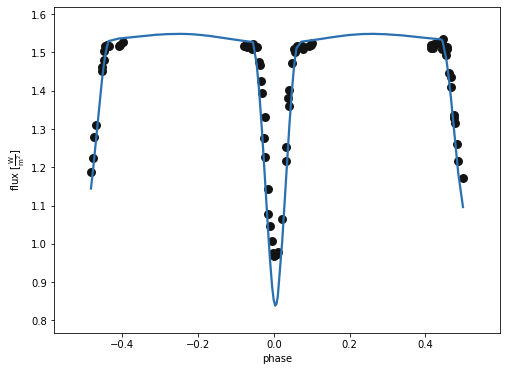

(<autofig.figure.Figure | 1 axes | 2 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [21]:
b.set_value(solution = 'lcgeom_solution', qualifier='adopt_parameters', value=['mask_phases'])
b.adopt_solution('lcgeom_solution')
b.plot(kind='lc', model='lcgeom_model', x='phases', show='True')

Previously we fit for the fractional sum of radii but we can now go back to having R1 and R2 as independent parameters.  Similarly we need to define the parameters to fit for.


In [22]:
b.flip_constraint('requiv@primary', solve_for='requivsumfrac@binary') 

b['fit_parameters'] = ['teffratio@binary','t0_supconj@binary','incl@binary']

In [23]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)


Wed, 14 Sep 2022 09:18 BUNDLE       WARNING fit_parameters contains a parameter (['t0_supconj']) that affects phasing which could cause issues with mask_phases
100%|██████████| 20/20 [04:27<00:00, 13.37s/it]


<ParameterSet: 11 parameters | qualifiers: success, adopt_values, niter, fitted_units, fitted_values, initial_values, fitted_twigs, message, comments, adopt_parameters, adopt_distributions>

Wed, 14 Sep 2022 09:23 BUNDLE       WARNING applying passed solution (nm_solution) to sample_from
Wed, 14 Sep 2022 09:23 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_solution=False
Wed, 14 Sep 2022 09:23 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [00:04<00:00,  4.82s/it]


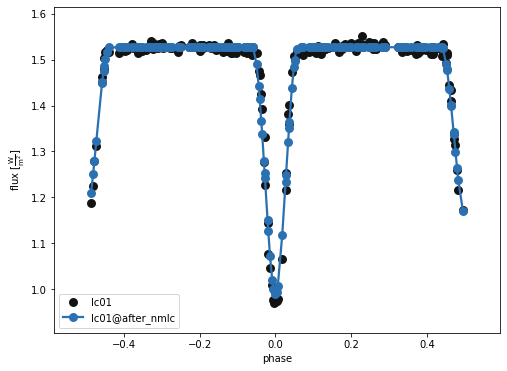

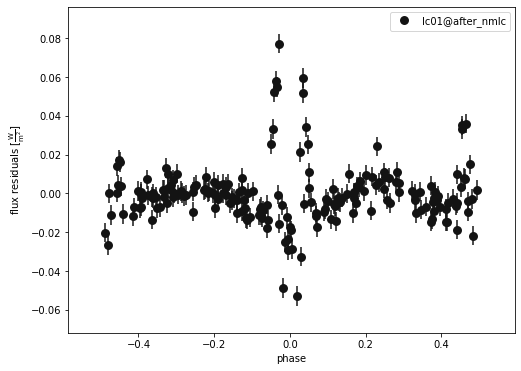

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [24]:
b.adopt_solution('nm_solution')
b.run_compute('nm_fit', solution='nm_solution', model='after_nmlc')
b['mask_enabled@lc01']=False #Turn of the phase masking for plotting
b.plot(kind='lc', model='after_nmlc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='after_nmlc', x='phases', y='residuals', show=True, legend=True, marker = 'o')

A closer look at the primary eclipse...

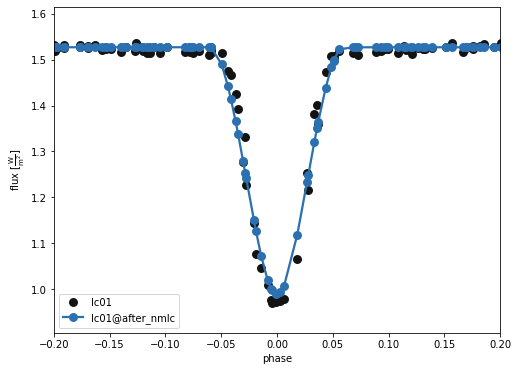

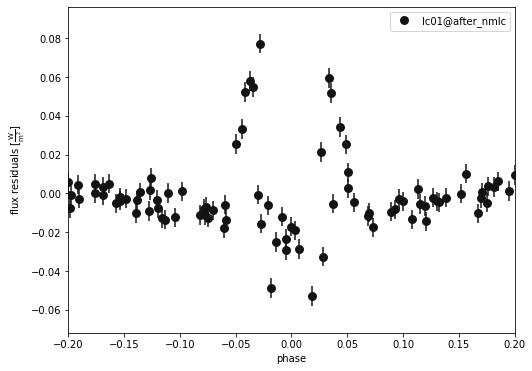

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [25]:
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', model='after_nmlc', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

Not awful, but we could improve by fitting everything together.  This will be expensive so we will only do this if we have time!

In [26]:
b.enable_dataset('rv01') #Enable the RV dataset
b['mask_enabled@lc01']=True #Turn on the phase masking again

Can fit for whatever we like, but often better to fit for a only a handful of parameters.

In [29]:
b['fit_parameters'].choices

['distance@system',
 'vgamma@system',
 'ebv@system',
 'Av@system',
 'Rv@system',
 'requiv@primary@star@component',
 'requiv_max@primary@star@component',
 'requiv_min@primary@star@component',
 'teff@primary@star@component',
 'abun@primary@star@component',
 'logg@primary@star@component',
 'syncpar@primary@star@component',
 'period@primary@star@component',
 'freq@primary@star@component',
 'pitch@primary@star@component',
 'yaw@primary@star@component',
 'incl@primary@star@component',
 'long_an@primary@star@component',
 'gravb_bol@primary@star@component',
 'irrad_frac_refl_bol@primary@star@component',
 'irrad_frac_lost_bol@primary@star@component',
 'ld_coeffs_bol[0]@primary@star@component',
 'ld_coeffs_bol[1]@primary@star@component',
 'mass@primary@star@component',
 'requiv@secondary@star@component',
 'requiv_max@secondary@star@component',
 'requiv_min@secondary@star@component',
 'teff@secondary@star@component',
 'abun@secondary@star@component',
 'logg@secondary@star@component',
 'syncpar@se

In [30]:
b['fit_parameters'] = ['t0_supconj@binary','teffratio@binary','requiv@primary','requivratio@binary','ecc@binary','per0@binary']

In [31]:
b.run_solver('nm_solver', solution='nm_solution', overwrite=True)


Wed, 14 Sep 2022 09:24 BUNDLE       WARNING fit_parameters contains a parameter (['t0_supconj', 'per0']) that affects phasing which could cause issues with mask_phases
100%|██████████| 20/20 [04:58<00:00, 14.90s/it]


<ParameterSet: 11 parameters | qualifiers: success, adopt_values, niter, fitted_units, fitted_values, initial_values, fitted_twigs, message, comments, adopt_parameters, adopt_distributions>

Wed, 14 Sep 2022 09:29 BUNDLE       WARNING applying passed solution (nm_solution) to sample_from
Wed, 14 Sep 2022 09:29 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_solution=False
Wed, 14 Sep 2022 09:29 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|██████████| 1/1 [00:08<00:00,  8.62s/it]


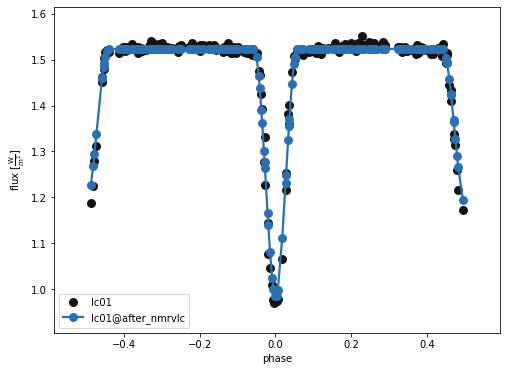

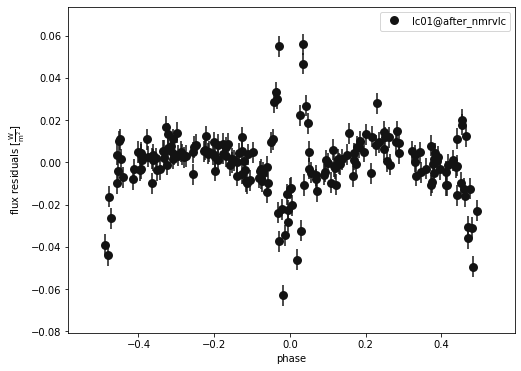

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [32]:
b.run_compute('nm_fit', solution='nm_solution', model='after_nmrvlc',overwrite=True)
b['mask_enabled@lc01']=False #Turn of the phase masking for plotting
b.plot(kind='lc', model='after_nmrvlc', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='after_nmrvlc', x='phases', y='residuals', show=True, legend=True, marker = 'o')

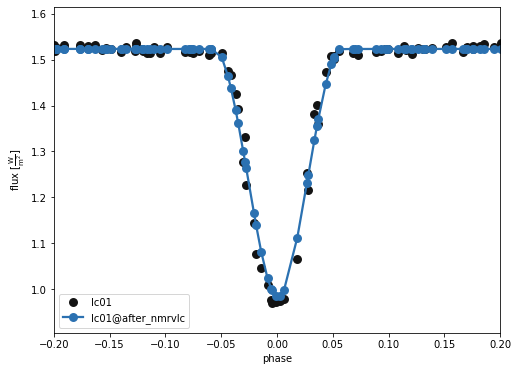

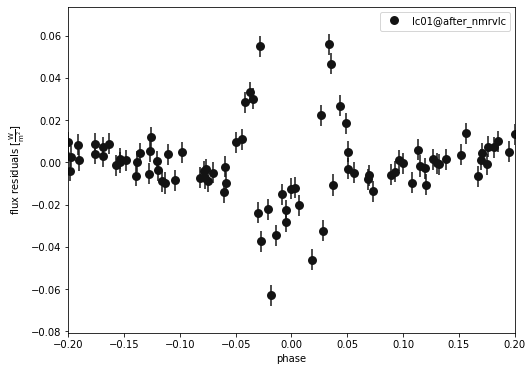

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [33]:
b.plot(kind='lc', x='phases', model='after_nmrvlc', xlim=[-0.2,0.2], show=True, legend=True, marker = 'o')
b.plot(kind='lc', x='phases', model='after_nmrvlc', xlim=[-0.2,0.2], y='residuals', show=True, legend=True, marker = 'o')

Can compare these new parameters to the old ones:

In [34]:
#Trial run allows us to see the fit parameters without adopting them
print(b.adopt_solution('nm_solution',trial_run=True)) 

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 1.23455809771073 d
   teffratio@binary@orbit@comp...: 0.9092681906886235
    requiv@primary@star@component: 1.4044329147588968 solRad
   requivratio@binary@orbit@co...: 1.030635708218095
       ecc@binary@orbit@component: 0.014705721991321426
      per0@binary@orbit@component: 91.01708603404344 deg


In [35]:
b['teffratio']

<Parameter: teffratio=0.9235518744809998 | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

Once you are happy that your fit is optimal, you should really sample around the solution using e.g. MCMC to probe the posterior distributions.  This is *VERY* computationally expensive, so we won't be able to do that here.  If you are interested, please join the next PHOEBE workshop! http://phoebe-project.org/workshops